<a href="https://colab.research.google.com/github/sethkipsangmutuba/Distributed-Computing-Application/blob/main/Note5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Socket API
**Seth Kipsang**

## Background

## The Socket Metaphor in Interprocess Communication

## The Datagram Socket API

## The Connectionless Datagram Socket (UDP)

## Connection-Oriented Datagram Semantics

## The Stream-Mode Socket API

## Reliable Byte Streams over TCP

## Operations and Event Synchronization

## Sockets with Nonblocking I/O Operations

## Secure Socket API

## The Secure Socket Layer and Transport Layer Security

## Secure Sockets in Python (ssl Module)

## Summary


# A1: The Socket API

## Overview

The socket API is the foundational programming interface for interprocess communication (IPC) in distributed systems. It provides a low-level abstraction that closely exposes network behavior and protocol semantics.

Although most applications rely on higher-level communication frameworks, understanding sockets is essential because:

- Higher-level IPC mechanisms are built on top of sockets.
- Performance-critical, resource-constrained, or telecom-grade systems often require direct socket use.

## Background

The socket API originated in BSD UNIX (early 1980s) as a standard interface for network communication. It is now supported across all major operating systems:

- Integrated into the kernel on UNIX/Linux systems
- Exposed via system libraries on Windows and macOS

Despite platform differences, socket APIs share a common message-passing model and similar semantics.

In Python, sockets are provided through the standard `socket` module, offering direct access to OS-level networking.


# A2 : The Socket Metaphor in IPC

The socket API borrows its terminology from telephony. A socket is a programming construct representing a communication endpoint.

A process wishing to communicate creates a socket instance.

Communication may be connection-oriented (reliable, e.g., TCP) or connectionless (unreliable, e.g., UDP).

In data networks:

- A packet is the unit of transmission.
- Each packet contains a payload (data) and a header (control information, including the destination address).

Conceptual model:

Process A ↔ Socket ↔ Network ↔ Socket ↔ Process B

This abstraction allows processes to communicate explicitly and uniformly across machines and networks.


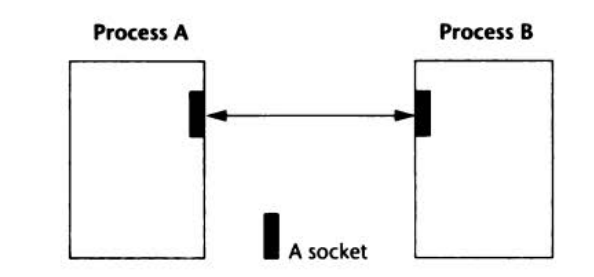

#A2 The Datagram Socket API

## Overview

At the transport layer, there are two key protocols:

- **UDP (User Datagram Protocol)** – connectionless, each packet (datagram) is addressed and routed independently. Delivery order is not guaranteed.
- **TCP (Transmission Control Protocol)** – connection-oriented, provides reliable, ordered delivery over a logical connection.

Datagram sockets use UDP and are simpler than stream sockets (TCP). They can operate in connectionless or connection-oriented modes at the application layer.

## Connectionless Datagram Socket

Key characteristics:

- Each datagram is sent independently, potentially taking different network paths.
- Multiple processes can send to the same socket; arrival order is unpredictable.
- A socket is bound to a local UDP port (0–65535; ports 0–1023 reserved).

Python usage:


In [45]:
import socket
import threading
import time

SERVER_ADDR = ('localhost', 2345)

def receiver():
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(SERVER_ADDR)
    data, addr = sock.recvfrom(1024)
    print(f"{len(data)} bytes received from {addr}: {data.decode()}")
    sock.close()

def sender():
    time.sleep(0.5)  # ensure receiver is ready
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(b'Hello world!', SERVER_ADDR)
    sock.close()

# Run receiver and sender concurrently
threading.Thread(target=receiver, daemon=True).start()
sender()


12 bytes received from ('127.0.0.1', 44019): Hello world!


## Notes:

- `sendto` and `recvfrom` handle datagrams.
- The receiver must bind to a specific port.
- One socket can communicate with multiple peers. Multiple sockets can be used to separate streams logically.

## Connection-Oriented Datagram Socket

The API can simulate a connection by binding and maintaining a logical association between sender and receiver.

Useful when repeated communication with the same peer is required, while still using UDP for lightweight transport.

## Key Python Socket Methods (UDP)

- `socket.socket(socket.AF_INET, socket.SOCK_DGRAM)` – create a datagram socket.
- `bind((host, port))` – bind the socket to a local address.
- `sendto(data, (host, port))` – send a datagram.
- `recvfrom(bufsize)` – receive a datagram.
- `close()` – close the socket.
- Optional: `settimeout(seconds)` – set blocking timeout for receive operations.


## Event Synchronization in Datagram Sockets

### Blocking and Nonblocking Behavior

Send operations are nonblocking: the process continues immediately after issuing a send.

Receive operations are blocking: the process is suspended until a datagram arrives.

### Timeout Handling

To prevent indefinite blocking, a timeout can be set (Python example):


In [46]:
import socket

# Create a UDP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

# Bind to localhost and let OS pick an available port
sock.bind(('localhost', 0))
print(f"Listening on {sock.getsockname()}")

# Set a timeout of 5 seconds (shorter for Colab)
sock.settimeout(5)

try:
    print("Waiting to receive a datagram...")
    data, addr = sock.recvfrom(1024)
    print(f"Received {data.decode()} from {addr}")
except socket.timeout:
    # This block executes if no datagram arrives in 5 seconds
    print("No datagram received within 5 seconds, exiting safely")

finally:
    sock.close()
    print("Socket closed, program finished")


Listening on ('127.0.0.1', 56287)
Waiting to receive a datagram...
No datagram received within 5 seconds, exiting safely
Socket closed, program finished


### Request–Response Pattern

Typical session: Client sends request → Server receives → Server sends response → Client receives.

Blocking calls naturally synchronize the two processes, but timeouts or asynchronous models may be used to avoid deadlocks.

### Simplex vs. Duplex Communication

Simplex (one-way): sender transmits, receiver receives.

Duplex (bidirectional): each process binds a socket to a local port to send and receive messages.

Multiple peers can communicate with a single socket or separate sockets for each peer.

### Important Considerations

- Datagram loss: if the receiver socket is not yet created, sent datagrams may be discarded.
- Buffer size: if the receiving buffer is smaller than the incoming datagram, data will be truncated.
- Concurrency: multiple processes can send to the same socket; the arrival order is unpredictable, reflecting UDP’s connectionless nature.

### Python Example (Simplex)


In [47]:
import socket
import threading
import time

def receiver():
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(('localhost', 2345))
    data, addr = sock.recvfrom(1024)
    print(f"Received: {data.decode()} from {addr}")
    sock.close()

def sender():
    time.sleep(0.5)  # ensure receiver is ready
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(b"Hello world!", ('localhost', 2345))
    sock.close()

threading.Thread(target=receiver, daemon=True).start()
sender()


Received: Hello world! from ('127.0.0.1', 33540)


### Python Example (Duplex)

Each process binds to its own port and uses `sendto` and `recvfrom` for bidirectional communication.

This pattern allows multiple peers to communicate over connectionless sockets while maintaining logical pairing.


# Connection-Oriented Datagram Sockets

## Overview

While datagram sockets (UDP) are inherently connectionless, some APIs allow a rudimentary connection to a specific remote socket.

This approach is uncommon and usually insufficient for applications that require full reliability or strict ordering. For robust connection-oriented communication, TCP (stream) sockets are preferred.

## Key Behavior

**Connecting a datagram socket:**

- Associates the socket with a single remote address and port.
- After connection, the socket only communicates with the specified peer.
- Packets from other sources are ignored.

**Disconnecting:**

- Terminates the connection, allowing the socket to send or receive from other peers.
- The connection is unilateral: only the local socket enforces the restriction.


###Receiver

In [48]:
import socket

recv_sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
recv_sock.bind(('localhost', 2345))
recv_sock.settimeout(5)  # prevent infinite blocking

try:
    data, addr = recv_sock.recvfrom(1024)
    print(f"Received: {data.decode()} from {addr}")
except socket.timeout:
    print("No data received within timeout window")
finally:
    recv_sock.close()


No data received within timeout window


####Sender

In [49]:
import socket

send_sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
send_sock.sendto(b"Hello", ('localhost', 2345))
send_sock.close()


#A3 : The Stream-Mode Socket API

# Stream-Mode Socket API (TCP Sockets)

## Overview

Unlike datagram sockets, stream-mode sockets support connection-oriented communication only.

- Data is transferred as a continuous stream, not as discrete packets.
- Writing and reading do not need to match in size: e.g., 100 bytes written can be read in multiple chunks (20 + 80 bytes).

## Conceptual Model

- Each process creates a stream socket.
- A connection is established between the sockets before data transfer.
- Data flows as a stream from sender → receiver.

**Server Side:**

- Uses two sockets:
  - **Connection socket** – listens and accepts incoming connections.
  - **Data socket** – handles actual send/receive operations.

**Client Side:**

- Creates a socket and requests a connection from the server.
- Once connected, can send/receive data over the data socket.

## Key Points

- TCP guarantees reliable, ordered delivery.
- Multiple clients can connect sequentially; each accepted connection gets a separate data socket.
- Stream-mode sockets are ideal for applications requiring persistent connections, such as file transfers, web servers, and chat applications.

## Python Example

**TCP Server + Client in One Colab Cell:**


In [50]:
import socket
import threading
import time

HOST = 'localhost'

def tcp_server(port_ready_event):
    server_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server_sock.bind((HOST, 0))  # OS chooses a free port
    port = server_sock.getsockname()[1]
    print(f"[Server] Listening on port {port}")

    server_sock.listen(1)
    port_ready_event.port = port
    port_ready_event.set()  # notify client the port is ready

    server_sock.settimeout(10)
    try:
        client_sock, addr = server_sock.accept()
        print(f"[Server] Connection from {addr}")
        client_sock.settimeout(5)
        data = client_sock.recv(1024)
        if data:
            print(f"[Server] Received: {data.decode()}")
            client_sock.sendall(b"ACK from server")
        client_sock.close()
    except socket.timeout:
        print("[Server] No client connected in time")
    finally:
        server_sock.close()
        print("[Server] Closed")

def tcp_client(port_ready_event):
    port_ready_event.wait()  # wait for server port
    port = port_ready_event.port
    client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_sock.settimeout(5)

    try:
        client_sock.connect((HOST, port))
        print(f"[Client] Connected to server on port {port}")
        client_sock.sendall(b"Hello from client")
        data = client_sock.recv(1024)
        print(f"[Client] Server says: {data.decode()}")
    finally:
        client_sock.close()
        print("[Client] Closed")

# Event to communicate the server port to the client
port_ready_event = threading.Event()
port_ready_event.port = None

# Run server and client in threads
server_thread = threading.Thread(target=tcp_server, args=(port_ready_event,))
client_thread = threading.Thread(target=tcp_client, args=(port_ready_event,))

server_thread.start()
client_thread.start()

server_thread.join()
client_thread.join()


[Server] Listening on port 42429
[Client] Connected to server on port 42429
[Server] Connection from ('127.0.0.1', 58734)
[Server] Received: Hello from client
[Server] Closed
[Client] Server says: ACK from server
[Client] Closed


# Operations and Event Synchronization in Stream-Mode Sockets

## Core Classes

### ServerSocket (Connection Socket)

- Listens for and accepts incoming connections.

**Key methods:**

- `ServerSocket(port)` – create a server socket on a given port.
- `accept()` – blocks until a connection request arrives; returns a data socket.
- `setSoTimeout(timeout)` – limits the blocking time of `accept()`.
- `close()` – closes the connection socket.

### Socket (Data Socket)

- Handles actual data transfer between connected peers.

**Key methods:**

- `Socket(address, port)` – connect to a server.
- `getInputStream()` / `getOutputStream()` – read/write data.
- `setSoTimeout(timeout)` – limits blocking for reads.
- `close()` – closes the data socket.

## Event Synchronization

**Blocking operations:**

- `accept()` – server waits until a client connects.
- `read()` on input stream – blocks until enough data is available.

**Nonblocking alternatives:**

- Use `setSoTimeout()` to avoid indefinite blocking.

**Data transfer:**

- Uses streams: data can be read/written in chunks of any size.
- Messages can be sent line-by-line (`readLine()/println()`) or partially (`read()/write()`).

## Program Flow

**Server (Connection Listener):**

1. Create `ServerSocket` and listen.
2. Accept connection → returns a `Socket`.
3. Get input/output streams from the `Socket`.
4. Read/write messages.
5. Close data socket, then connection socket.

**Client (Connection Requestor):**

1. Create a `Socket` with server host and port.
2. Get input/output streams.
3. Read/write messages.
4. Close the socket.

## Python Implementation (Single-shot, Blocking Example)


In [51]:
import socket
import threading
import time

HOST = 'localhost'
PORT = 5002  # pick a free port

def tcp_server(host: str, port: int):
    """
    TCP Stream-Mode Server.

    - Listens for a single client connection.
    - Receives a message from the client.
    - Sends an acknowledgment back.
    - Uses timeouts to avoid blocking forever.
    """
    server_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server_sock.bind((host, port))
    server_sock.listen(1)  # listen for 1 client
    server_sock.settimeout(10)  # timeout if no client connects

    print(f"[Server] Listening on {host}:{port} ...")

    try:
        client_sock, addr = server_sock.accept()
        print(f"[Server] Connection accepted from {addr}")

        client_sock.settimeout(5)
        data = client_sock.recv(1024)
        if data:
            print(f"[Server] Received: {data.decode()}")
            client_sock.sendall(b"ACK from server")  # send response

        client_sock.close()
        print("[Server] Client socket closed")
    except socket.timeout:
        print("[Server] No client connected within timeout")
    finally:
        server_sock.close()
        print("[Server] Server socket closed")


def tcp_client(host: str, port: int, message: str):
    """
    TCP Stream-Mode Client.

    - Connects to the server.
    - Sends a message.
    - Waits for the server acknowledgment.
    - Uses timeout to avoid hanging if server is not ready.
    """
    time.sleep(1)  # give the server time to start
    client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_sock.settimeout(5)

    try:
        client_sock.connect((host, port))
        print("[Client] Connected to server")

        client_sock.sendall(message.encode())
        data = client_sock.recv(1024)
        print(f"[Client] Server says: {data.decode()}")
    except socket.timeout:
        print("[Client] Connection attempt or receive timed out")
    except ConnectionRefusedError:
        print("[Client] Server refused connection")
    finally:
        client_sock.close()
        print("[Client] Client socket closed")


if __name__ == "__main__":
    # Run server and client in separate threads
    server_thread = threading.Thread(target=tcp_server, args=(HOST, PORT))
    client_thread = threading.Thread(target=tcp_client, args=(HOST, PORT, "Hello from client!"))

    server_thread.start()
    client_thread.start()

    server_thread.join()
    client_thread.join()

    print("[Main] TCP communication complete")


[Server] Listening on localhost:5002 ...
[Client] Connected to server
[Server] Connection accepted from ('127.0.0.1', 53900)
[Server] Received: Hello from client!
[Server] Client socket closed
[Server] Server socket closed
[Client] Server says: ACK from server
[Client] Client socket closed
[Main] TCP communication complete


## Key Points

- Stream-mode sockets provide TCP-style reliable, ordered streams.
- Blocking operations ensure proper event synchronization.
- Use timeouts to avoid indefinite suspension.
- For convenience, wrapper classes (e.g., `MyStreamSocket`) encapsulate read/write logic.

## Illustrative Concepts

**Event Diagram**

- **Server:** accept → read/write → close.
- **Client:** connect → write/read → close.

Messages are line-based or chunk-based, allowing flexible data streaming.

The approach scales for bidirectional communication and can be wrapped in classes to simplify client/server logic.


#A5 Sockets with Nonblocking I/O Operations

**Blocking I/O:** By default, a call to `recv()` or `accept()` suspends the process until data arrives or a connection is made. This is synchronous.

**Nonblocking I/O:** With nonblocking sockets, `recv()` and `send()` return immediately, even if no data is available. This allows a single thread to handle multiple sockets or perform other tasks concurrently.

## Python Implementation

- Set a socket to nonblocking using `.setblocking(False)`.
- Handle absence of data: `recv()` on a nonblocking socket raises a `BlockingIOError` if no data is available.
- Typical use-case: event-driven servers or high-concurrency applications where threads are expensive.


In [52]:
import socket
import time

HOST = 'localhost'
PORT = 5003

# Nonblocking server example
server_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
server_sock.bind((HOST, PORT))
server_sock.listen(1)
server_sock.setblocking(False)  # set nonblocking mode

print("[Server] Nonblocking server listening...")

start_time = time.time()
while time.time() - start_time < 10:  # run server for 10 seconds
    try:
        client_sock, addr = server_sock.accept()
        print(f"[Server] Connection from {addr}")
        client_sock.setblocking(False)  # also nonblocking
        try:
            data = client_sock.recv(1024)
            if data:
                print(f"[Server] Received: {data.decode()}")
                client_sock.sendall(b"ACK from server")
        except BlockingIOError:
            print("[Server] No data yet")
        client_sock.close()
    except BlockingIOError:
        # No client connection yet
        time.sleep(0.1)

server_sock.close()
print("[Server] Server stopped")


[Server] Nonblocking server listening...
[Server] Server stopped


## Key Points

- Asynchronous send/receive allows the server to continue doing other work instead of waiting.
- **Threads vs. nonblocking I/O:**
  - Threads: simpler but heavy if there are thousands of sockets.
  - Nonblocking sockets: efficient, scalable, but requires careful handling of `BlockingIOError` or event loops (like `selectors` in Python).
- **Python alternative:** The `selectors` module provides an efficient event-driven mechanism for managing many nonblocking sockets.


#A6 Secure Socket API (SSL/TLS)

## Conceptual Overview

Standard socket APIs transmit data as raw bit streams over a network.

These streams can be intercepted by tools (protocol analyzers), which poses a risk for sensitive data (passwords, credit cards, authentication tokens).

Secure Socket APIs add a layer of security by:

- Encrypting data before transmission
- Authenticating the server (and optionally the client)
- Ensuring message integrity

## Key Protocols

### SSL (Secure Sockets Layer)

- Developed by Netscape for private communications over the Internet.
- Encrypts data and ensures that it cannot be intercepted and read in plain text.
- Used in HTTPS (`https://` instead of `http://`).

### TLS (Transport Layer Security)

- Modern evolution of SSL.
- Provides stronger encryption and improved security features.

## Java Context

- JSSE (Java Secure Socket Extension) implements SSL/TLS in Java.
- Syntax is similar to standard `Socket` and `ServerSocket` APIs, but all communication is encrypted.
- Provides:
  - Server authentication
  - Optional client authentication
  - Data encryption and integrity checks

## Python Equivalent

- Python provides the `ssl` module to wrap TCP sockets with SSL/TLS:


In [53]:
import socket
import ssl

HOST = 'example.com'
PORT = 443  # HTTPS port

# Create a TCP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

# Create SSL context for client connections
context = ssl.create_default_context()

# Wrap the socket with the SSL context
ssl_sock = context.wrap_socket(sock, server_hostname=HOST)

try:
    # Connect to server
    ssl_sock.connect((HOST, PORT))
    print("Connected securely to server")

    # Send HTTP GET request
    request = "GET / HTTP/1.1\r\nHost: {}\r\n\r\n".format(HOST)
    ssl_sock.sendall(request.encode())

    # Receive and print response
    response = ssl_sock.recv(4096)
    print(response.decode())

finally:
    ssl_sock.close()


Connected securely to server
HTTP/1.1 200 OK
Date: Mon, 19 Jan 2026 05:08:26 GMT
Content-Type: text/html
Transfer-Encoding: chunked
Connection: keep-alive
CF-RAY: 9c03d06f5be7a391-ATL
last-modified: Tue, 13 Jan 2026 19:10:53 GMT
allow: GET, HEAD
Accept-Ranges: bytes
Age: 12511
cf-cache-status: HIT
Server: cloudflare




## Key Points

- Secure sockets are essential whenever sensitive data is transmitted.
- SSL/TLS secures the transport layer, not the application logic.
- APIs are similar to regular sockets, making it easier to switch an existing client/server to secure communication.
- In Python, SSL-wrapped sockets allow encryption and server authentication; in Java, JSSE provides equivalent functionality.


# Socket APIs for Interprocess Communication

Sockets provide a low-level API for processes to communicate over networks. Two major types were discussed: **datagram (UDP)** and **stream-mode (TCP)** sockets.

---

## 1. Datagram Sockets (UDP)

- **Nature:** Supports both connectionless and connection-oriented communication.
- **Objects:** Use `DatagramSocket` for sending/receiving; `DatagramPacket` encapsulates each datagram.
- **Behavior:**
  - **Send:** Nonblocking.
  - **Receive:** Blocking by default; can use `setSoTimeout` to avoid indefinite waiting.
  - **Connectionless Mode:** Can send/receive from any socket.
  - **Connection-Oriented Mode:** Limited to the remote socket attached to the connection.
  - **Data Handling:** Data is transmitted via byte arrays; insufficient buffer sizes truncate data.
- **Use Cases:** Applications needing fast, lightweight messaging where occasional packet loss is tolerable (e.g., streaming telemetry).

---

## 2. Stream-Mode Sockets (TCP)

- **Nature:** Supports connection-oriented communication only.
- **Roles:**
  - **Connection Acceptor (Server):** Uses `ServerSocket` to listen and accept connections; creates a data socket (`Socket`) per client.
  - **Connection Requestor (Client):** Uses `Socket` to request a connection to the server.
- **Operations:**
  - **Blocking:** `accept()` and `read()` operations.
  - **Nonblocking:** `write()` operations.
- **Data Handling:**
  - Continuous stream; writing and reading units do not need to match.
  - Streams decoupled: e.g., 100 bytes written can be read in multiple reads.
- **Concurrency:**
  - Threads are often used for parallel reads/writes.
  - Nonblocking APIs exist (e.g., Java NIO) to avoid threading overhead.
- **Use Cases:** Reliable, ordered communication (e.g., web servers, file transfers, chat applications).

---

## 3. Event Synchronization

- **Blocking Operations:**
  - Accepting a connection (`accept()`).
  - Reading from the socket (`read()`).
- **Nonblocking Operations:**
  - Writing to the socket (`write()`).
- **Asynchronous Options:**
  - Nonblocking I/O APIs let processes continue execution without waiting.
  - Requires event listeners or callbacks to handle incoming data.

---

## 4. Secure Socket Communication

- **Risk:** Unsecured sockets transmit raw bitstreams; vulnerable to interception and spoofing.
- **Secure Socket Layer (SSL):**
  - Encrypts data in transit.
  - Provides authentication and integrity.
- **Java Secure Socket Extension (JSSE):**
  - Implements SSL/TLS for Java applications.
  - API similar to standard stream-mode sockets.
- **Modern Python:** Use `ssl.SSLContext` to wrap sockets securely instead of `ssl.wrap_socket()`.

---

## 5. Summary of Key Differences

| Feature                  | Datagram (UDP)                          | Stream (TCP)                       |
|---------------------------|----------------------------------------|-----------------------------------|
| Communication Type        | Connectionless / Oriented              | Connection-oriented only           |
| Data Units                | Discrete datagrams                      | Continuous stream                  |
| Send/Receive Behavior     | Send nonblocking, Receive blocking      | Write nonblocking, Read blocking   |
| Reliability               | Unreliable (packets may be lost/reordered) | Reliable, ordered delivery         |
| Typical Use Cases         | Streaming telemetry, simple messaging  | Web servers, file transfer, chat   |
| Security                  | Not built-in                            | Can use SSL/TLS                    |
